# Getting started with OGGM: a real case study, step by step

The OGGM workflow is best explained with an example. In the following, we will show how to apply the standard [OGGM workflow](http://docs.oggm.org/en/stable/introduction.html) to a list of glaciers. This example is meant to guide you through a first-time setup step-by-step. If you prefer not to install OGGM on your computer, you can always run this notebook in [OGGM-Edu](https://edu.oggm.org) instead!

## Set-up 

### Input data folders

**If you are using your own computer**: before you start, make sure that you have set-up the [input data configuration file](https://docs.oggm.org/en/stable/input-data.html) at your wish.

In the course of this tutorial, we will need to download data needed for each glacier (a couple of mb at max, depending on the chosen glaciers), so make sure you have an internet connection.

### cfg.initialize() and cfg.PARAMS 

An OGGM simulation script will always start with the following commands:

In [1]:
from oggm import cfg, utils
cfg.initialize(logging_level='WARNING')

2021-02-09 12:05:32: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-09 12:05:32: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-02-09 12:05:32: oggm.cfg: Multiprocessing: using all available processors (N=8)


A call to [cfg.initialize()](https://docs.oggm.org/en/latest/generated/oggm.cfg.initialize.html) will read the default parameter file (or any user-provided file) and make them available to all other OGGM tools via the `cfg.PARAMS` dictionary. Here are some examples of these parameters:

In [5]:
cfg.PARAMS['prcp_scaling_factor'], cfg.PARAMS['ice_density'], cfg.PARAMS['continue_on_error']

(2.5, 900.0, False)

See [here](https://github.com/OGGM/oggm/blob/master/oggm/params.cfg) for the default parameter file and a description of their role and default value.

In [6]:
# You can try with or without multiprocessing: with two glaciers, OGGM could run on two processors
cfg.PARAMS['use_multiprocessing'] = True

## Workflow

In this section, we will explain the fundamental concepts of the OGGM workflow:
- Working directories
- Glacier directories
- Tasks

In [7]:
from oggm import workflow

### Working directory 

Each OGGM run needs a **single folder** where to store the results of the computations for all glaciers. This is called a "working directory" and needs to be specified before each run. Here we create a temporary folder for you:

In [8]:
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-GettingStarted', reset=True)
cfg.PATHS['working_dir']

'/tmp/OGGM/OGGM-GettingStarted'

We use a temporary directory for this example, but in practice you will set this working directory yourself (for example: `/home/john/OGGM_output`. The size of this directory will depend on how many glaciers you'll simulate!

**This working directory is meant to be persistent**, i.e. you can stop your processing workflow after any task, and restart from an existing working directory at a later stage.

### Define the glaciers for the run 

In [9]:
rgi_ids = ['RGI60-11.01328', 'RGI60-11.00897']

You can provide any number of glacier identifiers to OGGM. In this case, we chose: 
- `RGI60-11.01328`: [Unteraar Glacier](https://en.wikipedia.org/wiki/Unteraargletscher) in the Swiss Alps
- `RGI60-11.00897`: [Hintereisferner](http://acinn.uibk.ac.at/research/ice-and-climate/projects/hintereisferner) in the Austrian Alps.

Here is a list of other glaciers you might want to try out:
- `RGI60-18.02342`: Tasman Glacier in New Zealand
- `RGI60-11.00787`: [Kesselwandferner](https://de.wikipedia.org/wiki/Kesselwandferner) in the Austrian Alps
- ... or any other glacier identifier! You can find other glacier identifiers by exploring the [GLIMS viewer](https://www.glims.org/maps/glims).

For an operational run on an RGI region, you might want to download the [Randolph Glacier Inventory](https://www.glims.org/RGI/) dataset instead, and start a run from it. This case is covered in the [working with the RGI](working_with_rgi.ipynb) tutorial.

### Glacier directories 

The OGGM workflow is organized as a list of **tasks** that have to be applied to a list of glaciers. The vast majority of tasks are called **entity tasks**: they are standalone operations to be realized on one single glacier entity. These tasks are executed sequentially (one after another): they often need input generated by the previous task(s): for example, the climate calibration needs the glacier flowlines, which can be only computed after the topography data has been processed, and so on.

To handle this situation, OGGM uses a workflow based on data persistence on disk: instead of passing data as python variables from one task to another, each task will read the data from disk and then write the computation results back to the disk, making these new data available for the next task in the queue.

These glacier specific data are located in [glacier directories](https://docs.oggm.org/en/latest/glacierdir.html#glacier-directories). In the model, these directories are initialized with the following command (this can take a little while on the first call, as OGGM needs to download some data):

In [10]:
# Where to fetch the pre-processed directories
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=3, prepro_border=80)

2021-02-09 12:08:10: oggm.workflow: init_glacier_directories from prepro level 3 on 2 glaciers.
2021-02-09 12:08:10: oggm.workflow: Execute entity task gdir_from_prepro on 2 glaciers
100% of 189.1 MiB |######################| Elapsed Time: 0:01:08 Time:  0:01:08
100% of 194.1 MiB |######################| Elapsed Time: 0:01:13 Time:  0:01:13


- the keyword `from_prepro_level` indicates that we will start from [pre-processed directories](https://docs.oggm.org/en/latest/input-data.html#pre-processed-directories), i.e. data that are already pre-processed for the model users. In many cases you will want to start from level 3, 4 or 5. Here we start from level 3 and rerun some of the processing in order to demonstrate the OGGM workflow.
- the `prepro_border` keyword indicates the number of DEM grid points which we'd like to add to each side of the glacier for the local map: the larger the glacier will grow, the larger the border parameter should be. The available pre-processed border values are: **10, 80, 160** (depending on the model set-ups there might be more or less options). These are the fixed map sizes we prepared for you - any other map size will require a full processing (see the [alternative DEM example](dem_sources.ipynb) for a tutorial).

The [init_glacier_directories](https://docs.oggm.org/en/latest/generated/oggm.workflow.init_glacier_directories.html#oggm.workflow.init_glacier_directories) task will allways be the very first task to call for all your OGGM experiments. Let's see what it gives us back:

In [11]:
type(gdirs), type(gdirs[0])

(list, oggm.utils._workflow.GlacierDirectory)

`gdirs` is a list of [GlacierDirectory](https://docs.oggm.org/en/latest/generated/oggm.GlacierDirectory.html#oggm.GlacierDirectory) objects (one for each glacier). **Glacier directories are used by OGGM as "file and attribute manager"** for single glaciers. For example, the model now knows where to find the topography data file for this glacier:

In [12]:
gdir = gdirs[0]  # take Unteraar glacier
print('Path to the DEM:', gdir.get_filepath('dem'))

Path to the DEM: /tmp/OGGM/OGGM-GettingStarted/per_glacier/RGI60-11/RGI60-11.01/RGI60-11.01328/dem.tif


And we can also access some attributes of this glacier:

In [13]:
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-11.01328
  Region: 11: Central Europe
  Subregion: 11-01: Alps                            
  Glacier type: Glacier
  Terminus type: Land-terminating
  Area: 23.825 km2
  Lon, Lat: (8.2193, 46.5642)
  Grid (nx, ny): (299, 274)
  Grid (dx, dy): (78.0, -78.0)

In [14]:
gdir.rgi_date  # date at which the outlines are valid

2003

The advantage of this Glacier Directory data model is that it simplifies greatly the data transfer between tasks. **The single mandatory argument of all entity tasks will allways be a glacier directory**. With the glacier directory, each task will find the input it needs: for example, both the glacier's topography and outlines are needed for the next plotting function, and both are available via the `gdir` argument:

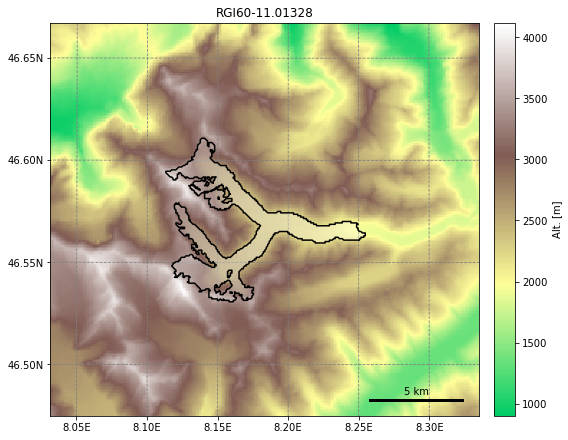

In [15]:
from oggm import graphics
graphics.plot_domain(gdir, figsize=(8, 7))

### Tasks

There are two different types of "[tasks](http://docs.oggm.org/en/latest/api.html#entity-tasks)":

**Entity Tasks**:
  Standalone operations to be realized on one single glacier entity,
  independently from the others. The majority of OGGM
  tasks are entity tasks. They are parallelisable: the same task can run on 
  several glaciers in parallel.

**Global Task**:
  Tasks which require to work on several glacier entities
  at the same time. Model parameter calibration or the 
  compilation of several glaciers' output are examples
  of global tasks. 
  
OGGM implements a simple mechanism to run a specific task on a list of `GlacierDirectory` objects:

In [16]:
from oggm import tasks

In [17]:
# run the glacier_masks task on all gdirs
workflow.execute_entity_task(tasks.glacier_masks, gdirs);

2021-02-09 12:12:29: oggm.workflow: Execute entity task glacier_masks on 2 glaciers


The task we just applied to our list of glaciers is [glacier_masks](http://docs.oggm.org/en/latest/generated/oggm.tasks.glacier_masks.html#oggm.tasks.glacier_masks). It wrote a new file in our glacier directory, providing raster masks of the glacier (among other things): 

In [18]:
print('Path to the masks:', gdir.get_filepath('gridded_data'))

Path to the masks: /tmp/OGGM/OGGM-GettingStarted/per_glacier/RGI60-11/RGI60-11.01/RGI60-11.01328/gridded_data.nc


It is also possible to apply several tasks sequentially (i.e. one after an other) on our glacier list:

In [19]:
list_talks = [
         tasks.compute_centerlines,
         tasks.initialize_flowlines,
         tasks.compute_downstream_line,
         ]
for task in list_talks:
    # The order matters!
    workflow.execute_entity_task(task, gdirs)

2021-02-09 12:13:01: oggm.workflow: Execute entity task compute_centerlines on 2 glaciers
2021-02-09 12:13:01: oggm.workflow: Execute entity task initialize_flowlines on 2 glaciers
2021-02-09 12:13:01: oggm.workflow: Execute entity task compute_downstream_line on 2 glaciers


The function `execute_task` can run a task on different glaciers at the same time, if the `use_multiprocessing` option is set to `True` in the configuration file. 

Among other things, we computed the glacier flowlines and the glacier's downstream line. We can now plot them:

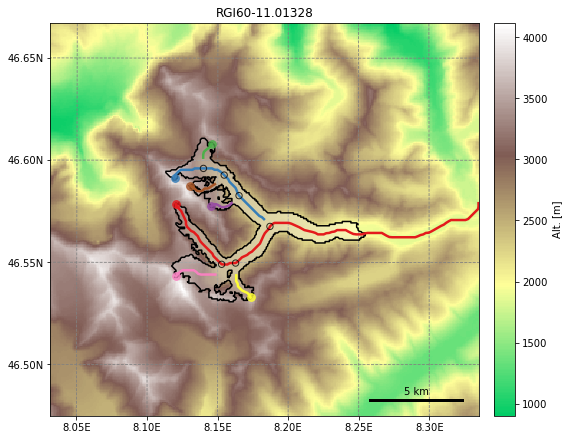

In [20]:
graphics.plot_centerlines(gdir, figsize=(8, 7), use_flowlines=True, add_downstream=True)

As a result, the glacier directories now store many more files. If you are interested, you can have a look:

In [21]:
import os
print(os.listdir(gdir.dir))

['gridded_data.nc', 'downstream_line.pkl', 'catchments_intersects.tar.gz', 'flowline_catchments.tar.gz', 'log.txt', 'geometries.pkl', 'model_flowlines.pkl', 'climate_historical.nc', 'intersects.tar.gz', 'climate_info.json', 'dem.tif', 'local_mustar.json', 'outlines.tar.gz', 'centerlines.pkl', 'inversion_input.pkl', 'glacier_grid.json', 'dem_source.txt', 'diagnostics.json', 'inversion_output.pkl', 'inversion_flowlines.pkl']


For a short explanation of what these files are, see the [glacier directory documentation](https://docs.oggm.org/en/latest/glacierdir.html#cfg-basenames)BROKEN LINK. In practice, however, you will only rarely need to access these files yourself.

### Other preprocessing tasks 

Let's continue with the other preprocessing tasks: 

In [22]:
list_talks = [
         tasks.catchment_area,
         tasks.catchment_width_geom,
         tasks.catchment_width_correction,
         tasks.compute_downstream_bedshape
         ]
for task in list_talks:
    # The order matters!
    workflow.execute_entity_task(task, gdirs)

2021-02-09 12:20:44: oggm.workflow: Execute entity task catchment_area on 2 glaciers
2021-02-09 12:20:46: oggm.workflow: Execute entity task catchment_width_geom on 2 glaciers
2021-02-09 12:20:48: oggm.workflow: Execute entity task catchment_width_correction on 2 glaciers
2021-02-09 12:20:48: oggm.workflow: Execute entity task compute_downstream_bedshape on 2 glaciers


We just computed the catchment areas of each flowline (the colors are arbitrary):

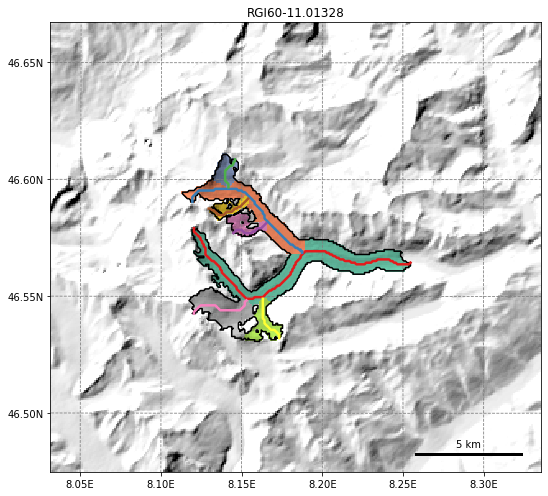

In [23]:
graphics.plot_catchment_areas(gdir, figsize=(8, 7))

Each flowline now knows what area will contribute to its surface mass-balance and ice flow. Accordingly, it is possible to compute each glacier cross-section's width, and correct it so that the total glacier area and elevation distribution is conserved: 

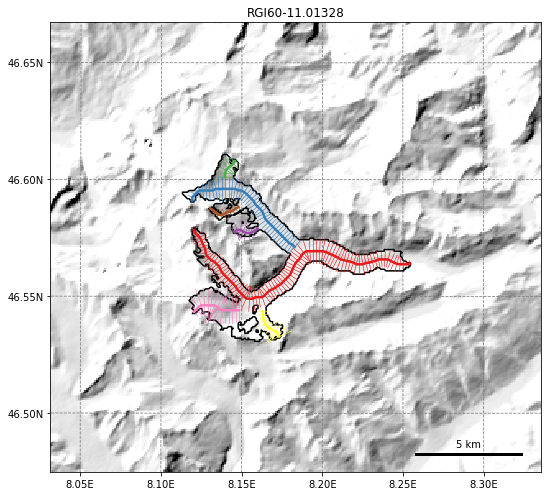

In [24]:
graphics.plot_catchment_width(gdir, corrected=True, figsize=(8, 7))

### Climate tasks 

The glacier directories we downloaded already contains the climate timeseries for each glacier (`from_prepro_level=3`). Let's have a look at them:

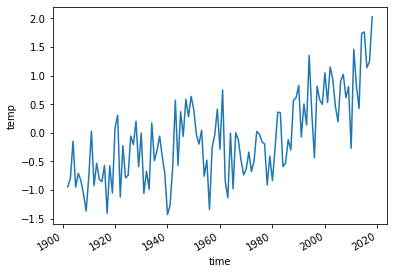

In [25]:
import xarray as xr
fpath = gdir.get_filepath('climate_historical')
ds = xr.open_dataset(fpath)
# Data is in hydrological years
# -> let's just ignore the first and last calendar years
ds.temp.resample(time='AS').mean()[1:-1].plot();

This climate data is called the "baseline climate" for this glacier. It will be used for the mass-balance model calibration, and at the end of this tutorial also to generate the random climate to drive a simulation. When running OGGM with GCM data, the GCM timeseries will be computed as anomalies to this baseline timeseries, hence the name.

Here we are using CRU, but OGGM-Shop also allows to use ERA5 and CERA as baseline.

Now, let's calibrate the mass-balance model for this glacier. The calibration procedure of OGGM is ... original, but is also quite powerful. Read the [doc page](https://docs.oggm.org/en/latest/mass-balance.html) or the [GMD paper](https://www.geosci-model-dev-discuss.net/gmd-2018-9/) for more details, and you can also follow the [mass-balance calibration tutorial](massbalance-calibration.ipynb) explaining some of the model internals.

The default calibration process is automated:

In [26]:
# Fetch the reference t* list and associated model parameters
params_url = 'https://cluster.klima.uni-bremen.de/~oggm/ref_mb_params/RGIV62/CRU/centerlines/qc3/pcp2.5'
workflow.download_ref_tstars(base_url=params_url)
# Now calibrate
workflow.execute_entity_task(tasks.local_t_star, gdirs);
workflow.execute_entity_task(tasks.mu_star_calibration, gdirs);

2021-02-09 12:21:36: oggm.workflow: Execute entity task local_t_star on 2 glaciers
2021-02-09 12:21:36: oggm.workflow: Execute entity task mu_star_calibration on 2 glaciers


**¡Important!** The calibration of the mass-balance model is automated only for certain parameter combinations of the model - any change in the mass-balance model settings (e.g. the melt threshold, the precipitation correction factor, etc.) will require a re-calibration of the model (see the [mass-balance calibration tutorial](massbalance-calibration.ipynb) for an introduction to this topic).

From there, OGGM can now compute the mass-balance for these glaciers. For example:

In [27]:
from oggm.core.massbalance import MultipleFlowlineMassBalance
gdir_hef = gdirs[1]
mbmod = MultipleFlowlineMassBalance(gdir_hef, use_inversion_flowlines=True)

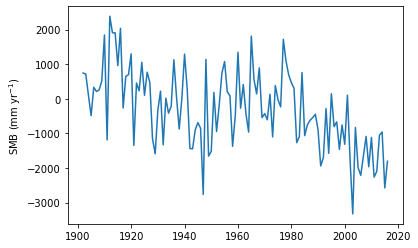

In [28]:
import numpy as np
import matplotlib.pyplot as plt
years = np.arange(1902, 2017)
mb_ts = mbmod.get_specific_mb(year=years)
plt.plot(years, mb_ts); plt.ylabel('SMB (mm yr$^{-1}$)');

For the Hintereiferner (not for Unteraar where no observational data is available), we can also compare our computed mass-balance to the measured one:

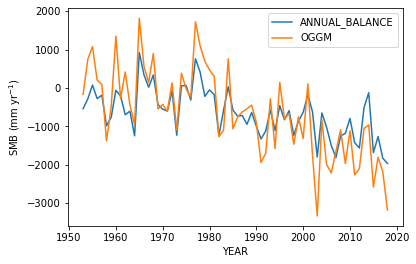

In [29]:
mbdf = gdir_hef.get_ref_mb_data()
mbdf['OGGM'] = mbmod.get_specific_mb(year=mbdf.index)
mbdf[['ANNUAL_BALANCE', 'OGGM']].plot(); plt.ylabel('SMB (mm yr$^{-1}$)');

This graphic is interesting because it shows an effect often observed when comparing the computed mass balance to the observed one: since (in this case) the OGGM geometry is fixed with time, the modelled specific mass-balance series are likely to have a stronger trend than the observed ones.

To assess the results of the OGGM mass-balance model for all WGMS glaciers worldwide, visit the [score summary](https://cluster.klima.uni-bremen.de/~oggm/ref_mb_params/RGIV62/CRU/centerlines/qc3/pcp2.5/_scores/) for this particular model settings.

### Computing the ice thickness ("inversion")

With the computed mass-balance and the flowlines, OGGM can now compute the ice thickness, based on the principles of [mass conservation and ice dynamics](http://docs.oggm.org/en/latest/inversion.html). 

In [30]:
list_talks = [
         tasks.prepare_for_inversion,  # This is a preprocessing task
         tasks.mass_conservation_inversion,  # This does the actual job
         tasks.filter_inversion_output  # This smoothes the thicknesses at the tongue a little
         ]
for task in list_talks:
    workflow.execute_entity_task(task, gdirs)

2021-02-09 12:25:08: oggm.workflow: Execute entity task prepare_for_inversion on 2 glaciers
2021-02-09 12:25:08: oggm.workflow: Execute entity task mass_conservation_inversion on 2 glaciers
2021-02-09 12:25:08: oggm.workflow: Execute entity task filter_inversion_output on 2 glaciers


The ice thickness is computed for all sections along the flowline, and can be displayed with the help of OGGM's graphics module:

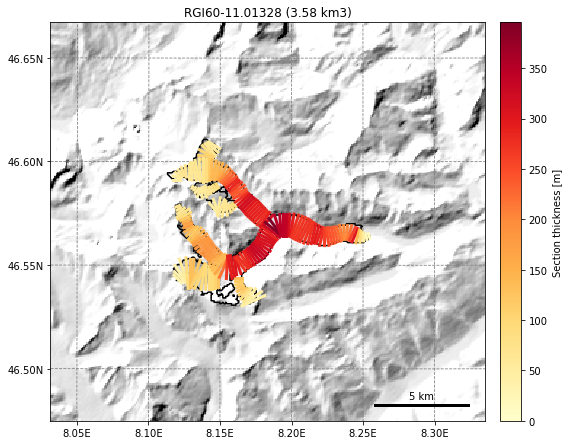

In [31]:
graphics.plot_inversion(gdir, figsize=(8, 7))

The inversion is realized with the default parameter settings: it must be noted that the model is sensitive to the choice of some of them, most notably the creep parameter A:

In [32]:
cfg.PARAMS['inversion_glen_a']

2.4e-24

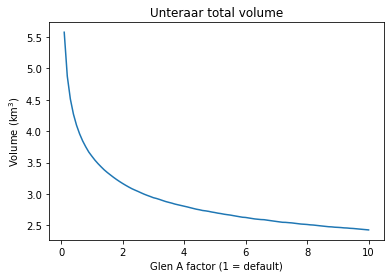

In [33]:
a_factor = np.linspace(0.1, 10., 100)
volume = []
for f in a_factor:
    # Recompute the volume without overwriting the previous computations
    v = tasks.mass_conservation_inversion(gdir, glen_a=f * cfg.PARAMS['inversion_glen_a'], write=False)
    volume.append(v * 1e-9)
plt.plot(a_factor, volume); plt.title('Unteraar total volume');
plt.ylabel('Volume (km$^3$)'); plt.xlabel('Glen A factor (1 = default)'); 

There is no simple way to find the best A for each individual glacier. It can easily vary by a factor of 10 (or more) from one glacier to another. At the global scale, the "best" A is close to the default value (possibly between 1 and 1.5 times larger). The default parameter a good choice in a first step but be aware that reconstructions based on this default parameter might be very uncertain! See our [ice thickness inversion tutorial](inversion.ipynb) for a more in-depth discussion.

## Simulations 

For most applications, this is where the fun starts! With climate data and an estimate of the ice thickness, we can now start transient simulations. For this tutorial, we will show how to realize idealized experiments based on the baseline climate only, but it is also possible to drive OGGM with real GCM data.

In [34]:
# Convert the flowlines to a "glacier" for the ice dynamics module
workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs);

2021-02-09 12:27:52: oggm.workflow: Execute entity task init_present_time_glacier on 2 glaciers


Let's start a run driven by a the climate of the last 31 years, shuffled randomly for 200 years. This can be seen as a "commitment" simulation, i.e. how much glaciers will change even without further climate change:

In [35]:
workflow.execute_entity_task(tasks.run_random_climate, gdirs, nyears=200,
                             y0=2000, output_filesuffix='_2000');

2021-02-09 12:27:53: oggm.workflow: Execute entity task run_random_climate on 2 glaciers


The output of this simulation is stored in two separate files: a diagnostic file (which contains time series variables such as length, volume, ELA, etc.) and a full model output file, which is larger but allows to reproduce the full glacier geometry changes during the run.

In practice, the diagnostic files are often compiled for the entire list of glaciers:

In [36]:
ds2000 = utils.compile_run_output(gdirs, filesuffix='_2000')

2021-02-09 12:28:07: oggm.utils: Applying compile_run_output on 2 gdirs.


This dataset is also stored on disk (in the working directory) as NetCDF file for later use. Here we can access it directly:

In [37]:
ds2000

<xarray.Dataset>
Dimensions:         (rgi_id: 2, time: 201)
Coordinates:
  * time            (time) float64 0.0 1.0 2.0 3.0 ... 197.0 198.0 199.0 200.0
  * rgi_id          (rgi_id) <U14 'RGI60-11.01328' 'RGI60-11.00897'
    hydro_year      (time) int64 0 1 2 3 4 5 6 7 ... 194 195 196 197 198 199 200
    hydro_month     (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    calendar_year   (time) int64 -1 0 1 2 3 4 5 ... 193 194 195 196 197 198 199
    calendar_month  (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10 10
Data variables:
    volume          (time, rgi_id) float64 3.577e+09 8.976e+08 ... 2.427e+08
    volume_bsl      (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    volume_bwl      (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    area            (time, rgi_id) float64 2.382e+07 8.036e+06 ... 4.167e+06
    length          (time, rgi_id) float64 1.342e+04 6.9e+03 ... 1.4e+03
    calving         (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    calving_rate    (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    water_level     (rgi_id) float64 0.0 0.0
    glen_a          (rgi_id) float64 2.4e-24 2.4e-24
    fs              (rgi_id) float64 0.0 0.0
Attributes:
    description:    OGGM model output
    oggm_version:   1.3.2.dev136+g01a7607
    calendar:       365-day no leap
    creation_date:  2021-02-09 11:28:07

We opened the file with [xarray](http://xarray.pydata.org), a very useful data analysis library based on [pandas](http://pandas.pydata.org/). For example, we can plot the volume and length evolution of both glaciers with time:

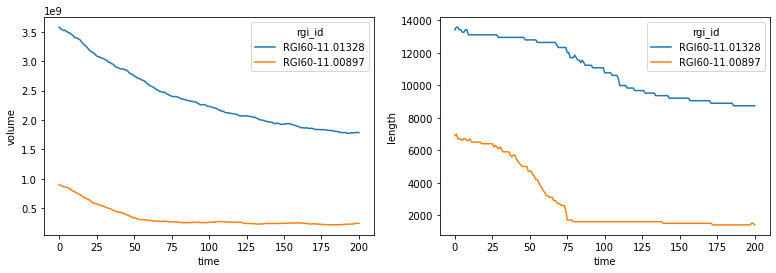

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
ds2000.volume.plot.line(ax=ax1, hue='rgi_id');
ds2000.length.plot.line(ax=ax2, hue='rgi_id');

The full model output files can be used for plots:

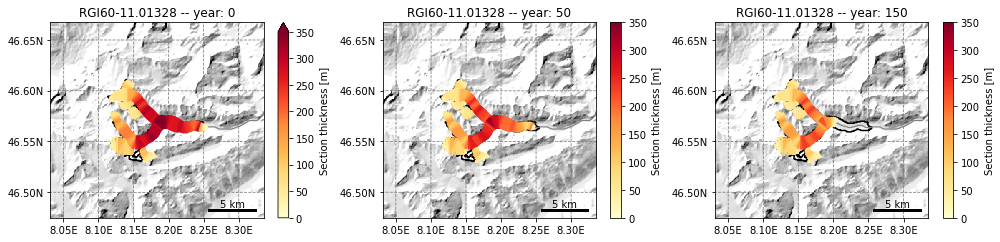

In [39]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))
graphics.plot_modeloutput_map(gdir, filesuffix='_2000', modelyr=0, ax=ax1, vmax=350)
graphics.plot_modeloutput_map(gdir, filesuffix='_2000', modelyr=50, ax=ax2, vmax=350)
graphics.plot_modeloutput_map(gdir, filesuffix='_2000', modelyr=150, ax=ax3, vmax=350)
plt.tight_layout();

### Sensitivity to temperature 

Now repeat our simulations with a +0.5°C and -0.5°C temperature bias, which for a glacier is quite a lot!

In [40]:
workflow.execute_entity_task(tasks.run_random_climate, gdirs, nyears=200,
                             temperature_bias=0.5,
                             y0=2000, output_filesuffix='_p05');
workflow.execute_entity_task(tasks.run_random_climate, gdirs, nyears=200,
                             temperature_bias=-0.5,
                             y0=2000, output_filesuffix='_m05');

2021-02-09 12:29:21: oggm.workflow: Execute entity task run_random_climate on 2 glaciers
2021-02-09 12:29:33: oggm.workflow: Execute entity task run_random_climate on 2 glaciers


In [41]:
dsp = utils.compile_run_output(gdirs, filesuffix='_p05')
dsm = utils.compile_run_output(gdirs, filesuffix='_m05')

2021-02-09 12:29:48: oggm.utils: Applying compile_run_output on 2 gdirs.
2021-02-09 12:29:48: oggm.utils: Applying compile_run_output on 2 gdirs.


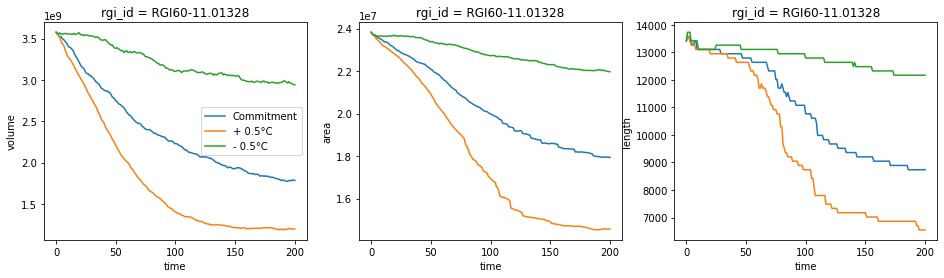

In [43]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
rgi_id = 'RGI60-11.01328'
ds2000.sel(rgi_id=rgi_id).volume.plot.line(ax=ax1, hue='rgi_id', label='Commitment');
ds2000.sel(rgi_id=rgi_id).area.plot.line(ax=ax2, hue='rgi_id');
ds2000.sel(rgi_id=rgi_id).length.plot.line(ax=ax3, hue='rgi_id');
dsp.sel(rgi_id=rgi_id).volume.plot.line(ax=ax1, hue='rgi_id', label='+ 0.5°C');
dsp.sel(rgi_id=rgi_id).area.plot.line(ax=ax2, hue='rgi_id');
dsp.sel(rgi_id=rgi_id).length.plot.line(ax=ax3, hue='rgi_id');
dsm.sel(rgi_id=rgi_id).volume.plot.line(ax=ax1, hue='rgi_id', label='- 0.5°C');
dsm.sel(rgi_id=rgi_id).area.plot.line(ax=ax2, hue='rgi_id');
dsm.sel(rgi_id=rgi_id).length.plot.line(ax=ax3, hue='rgi_id');
ax1.legend();

From this experiment, we learn that a climate that is -0.5° colder than today (the mean climate of 1985-2015) would barely be enough to maintain the Unteraar glacier in its present day geometry. 

## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)